## Import necessary libraries
In this section, we import all the necessary libraries for image processing, visualization, and analysis. These libraries include:

- `nibabel` for loading and saving medical imaging data.
- `numpy` for numerical operations.
- `matplotlib` for plotting and visualization.
- `skimage` for image processing tasks.
- `scipy` for scientific computing.
- `mayavi` for 3D visualization.
- `ipywidgets` for interactive widgets in Jupyter notebooks.
- `IPython.display` for displaying widgets and outputs.



In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, morphology
from skimage.transform import resize
from scipy.ndimage import binary_closing, binary_opening
from mayavi import mlab
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, Output, VBox
from IPython.display import display
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from scipy import ndimage as ndi

## Function to plot 2d slices
To visualize 2D slices of a volumetric image, we use the `plot_with_ipywidgets` function. This function allows us to interactively explore the slices along a specified axis using a slider. The function takes the following parameters:

- `organs_mask`: A 3D numpy array representing the volumetric image.
- `slice_axis`: The axis along which the slices are taken (0, 1, or 2).

The function creates an interactive slider to navigate through the slices and updates the displayed image accordingly. This is useful for examining different sections of the volumetric data.

In [2]:

def plot_with_ipywidgets(organs_mask, slice_axis=2):
    """
    Visualizza un'immagine volumetrica `organs_mask` con uno slider interattivo
    per cambiare la slice visualizzata.

    Args:
        organs_mask (numpy.ndarray): Volume binario da visualizzare.
        slice_axis (int): Asse lungo il quale effettuare le sezioni (0, 1 o 2).
    """
    # Creare un'area di output separata
    output = Output()

    # Funzione per aggiornare la visualizzazione
    def update(slice_index):
        with output:
            output.clear_output(wait=True)
            plt.figure(figsize=(8, 8))
            if slice_axis == 0:
                slice_data = organs_mask[slice_index, :, :]
            elif slice_axis == 1:
                slice_data = organs_mask[:, slice_index, :]
            else:
                slice_data = organs_mask[:, :, slice_index]
            
            plt.imshow(slice_data, cmap='gray')
            plt.title(f"Slice {slice_index} lungo l'asse {slice_axis}")
            plt.axis('off')
            plt.show()

    # Crea uno slider
    slider = IntSlider(min=0, max=organs_mask.shape[slice_axis] - 1, step=1, value=0)
    slider.observe(lambda change: update(change['new']), names='value')

    # Layout con slider e output
    ui = VBox([slider, output])

    # Inizializza la visualizzazione
    update(0)
    display(ui)


## Function to filter lung
The `filtra_polmoni` function processes a 3D volumetric image to segment the lungs. The function performs the following steps:

1. **Thresholding**: Identifies potential lung regions by thresholding the image.
2. **Clear Border**: Removes objects connected to the image border to isolate the lungs.
3. **Morphological Operations**: Applies binary closing and opening to refine the lung mask.
4. **Remove Trachea**: Eliminates small regions, such as the trachea, based on area.
5. **Labeling**: Labels connected components in the binary mask.
6. **Filter Blobs**: Keeps only the two largest blobs, which correspond to the lungs.
7. **Fill Holes**: Fills holes within the lung regions to create a solid mask.

The function returns a binary mask of the segmented lungs.

In [3]:
def filtra_polmoni(data_resized):
    organs_mask = data_resized < -500
    cleared_organs_mask = np.zeros_like(organs_mask)
    for i in range(organs_mask.shape[2]):
        cleared_organs_mask[:, :, i] = clear_border(organs_mask[:, :, i])
    organs_mask = cleared_organs_mask
    #plot_with_ipywidgets(organs_mask, slice_axis=2)
    organs_mask_closed=np.zeros_like(organs_mask)
    organs_mask_cleaned=np.zeros_like(organs_mask)
    for i in range(organs_mask.shape[2]):
        selem = morphology.disk(3)  # Elemento strutturante sferico di raggio 3
        organs_mask_closed[:,:,i] = binary_closing(organs_mask[:,:,i], structure=selem)
        organs_mask_cleaned[:,:,i] = binary_opening(organs_mask_closed[:,:,i], structure=selem)

    def remove_trachea(slc, c=0.01):
        new_slc = slc.copy()
        labels = label(slc,connectivity=1,background=0)
        rps = regionprops(labels)
        areas = np.array([r.area for r in rps])
        idxs = np.where(areas/(slc.shape[0]*slc.shape[1]) < c)[0]
        for i in idxs:
            new_slc[tuple(rps[i].coords.T)] = 0
        return new_slc
    
    organs_mask_cleaned = np.vectorize(remove_trachea, signature='(n,m)->(n,m)')(organs_mask_cleaned)
    labeled_volume = label(organs_mask_cleaned,background=0)
    blob_properties = measure.regionprops(labeled_volume)
    for prop in blob_properties:
        if prop.centroid[2] < data_resized.shape[2] / 2 or prop.centroid[1]<data_resized.shape[1]/3:
            labeled_volume[labeled_volume == prop.label] = 0
    
    blob_properties = measure.regionprops(labeled_volume)
    # Trova i due blob con area maggiore
    blob_areas = [(prop.area, prop.label) for prop in blob_properties]
    blob_areas_sorted = sorted(blob_areas, reverse=True)[:2]

    # Crea una maschera vuota
    mask = np.zeros_like(labeled_volume)

    # Imposta a 1 i due blob con area maggiore
    for _, labelx in blob_areas_sorted:
        mask[labeled_volume == labelx] = 1

    mask = np.vectorize(ndi.binary_fill_holes, signature='(n,m)->(n,m)')(mask)
    #plot_with_ipywidgets(mask, slice_axis=2)
    # Calcola i centri di massa dei blob
    #plot_3d_label(mask)

    
    return mask

def plot_3d_label( labeled_volume, label_number=1,voxel_dimensions=(1, 1, 1)):
    # Crea una maschera binaria per la label specificata
    label_mask = labeled_volume == label_number

    # Trova i contorni della maschera
    verts, faces, _, _ = measure.marching_cubes(label_mask, level=0, spacing=voxel_dimensions)

    # Crea una figura 3D con mlab
    mlab.figure(size=(800, 800))
    mlab.triangular_mesh(verts[:, 0], verts[:, 1], verts[:, 2], faces, color=(1, 0, 0))
    #mlab.title(f"3D Plot della label {label_number}")
    mlab.show()




def dice_score(mask1, mask2):
    """
    Calcola il Dice Score tra due maschere volumetriche.

    Args:
        mask1 (numpy.ndarray): Prima maschera binaria.
        mask2 (numpy.ndarray): Seconda maschera binaria.

    Returns:
        float: Dice Score.
    """
    intersection = np.sum(mask1 * mask2)
    volume_sum = np.sum(mask1) + np.sum(mask2)
    if volume_sum == 0:
        return 1.0  # Se entrambe le maschere sono vuote, il Dice Score è 1
    return 2.0 * intersection / volume_sum


    

   

## Read .nii.gz MRI image


In [13]:
# Carica il file .nii
img = nib.load('C:\\Users\\alber\\Desktop\\OrganSegmentations\\volume-4.nii.gz')
header = img.header
voxel_dimensions = header.get_zooms()
data = img.get_fdata()

img = nib.load('C:\\Users\\alber\\Desktop\\OrganSegmentations\\labels-4.nii.gz')
true_lung = img.get_fdata()
true_lung = np.where(np.isclose(true_lung,3), 1, 0)#necessary in ct-org dataset, lungs are labeled as 3


## Launch filter on image

In [14]:
predicted_lung = filtra_polmoni(data)
plot_3d_label(predicted_lung,voxel_dimensions=voxel_dimensions)#3d plot of the predicted lung

## Evaluation
In this section, we evaluate the performance of the lung segmentation algorithm. We iterate through a set of volumetric images, apply the segmentation algorithm, and compute the Dice Score for each image. The Dice Score is a measure of overlap between the predicted lung mask and the ground truth mask, with a higher score indicating better performance.



In [6]:
import os

dice_scores=[]
base_path = 'C:\\Users\\alber\\Desktop\\OrganSegmentations\\'

for i in range(1, 131):
    print("Iteration number: ", i)
    volume_path = os.path.join(base_path, f'volume-{i}.nii.gz')
    label_path = os.path.join(base_path, f'labels-{i}.nii.gz')
    
    if not os.path.exists(volume_path):
        print(f"File {volume_path} not found, skipped")
        continue
    
    img = nib.load(volume_path)
    header = img.header
    voxel_dimensions = header.get_zooms()
    data = img.get_fdata()

    img = nib.load(label_path)
    true_lung = img.get_fdata()
    true_lung = np.where(np.isclose(true_lung, 3), 1, 0)

    predicted_lung = filtra_polmoni(data)
    dice_score1 = dice_score(true_lung, predicted_lung)
    dice_scores.append((dice_score1, i))
    print(f"Dice Score: {dice_score1}")
    

average_dice_score = np.mean([score[0] for score in dice_scores])
print(f"Average Dice Score: {average_dice_score}")



Iteration number:  1
Dice Score: 0.9295927824164076
Iteration number:  2
Dice Score: 0.9834672353403504
Iteration number:  3
Dice Score: 0.96582914685773
Iteration number:  4
Dice Score: 0.9700316142122399
Iteration number:  5
Dice Score: 0.9614732356944107
Iteration number:  6
Dice Score: 0.9513698007974583
Iteration number:  7
Dice Score: 0.9575958402440549
Iteration number:  8
Dice Score: 0.9393769235534212
Iteration number:  9
Dice Score: 0.9444620020162889
Iteration number:  10
Dice Score: 0.9538115234788541
Iteration number:  11
Dice Score: 0.9544184480605543
Iteration number:  12
Dice Score: 0.9567590703991621
Iteration number:  13
Dice Score: 0.9558756557457941
Iteration number:  14
Dice Score: 0.9674535251626352
Iteration number:  15
Dice Score: 0.9659441945466679
Iteration number:  16
Dice Score: 0.9551998661277786
Iteration number:  17
Dice Score: 0.9607446630510402
Iteration number:  18
Dice Score: 0.9039154524552202
Iteration number:  19
Dice Score: 0.8689674786653199
Iter

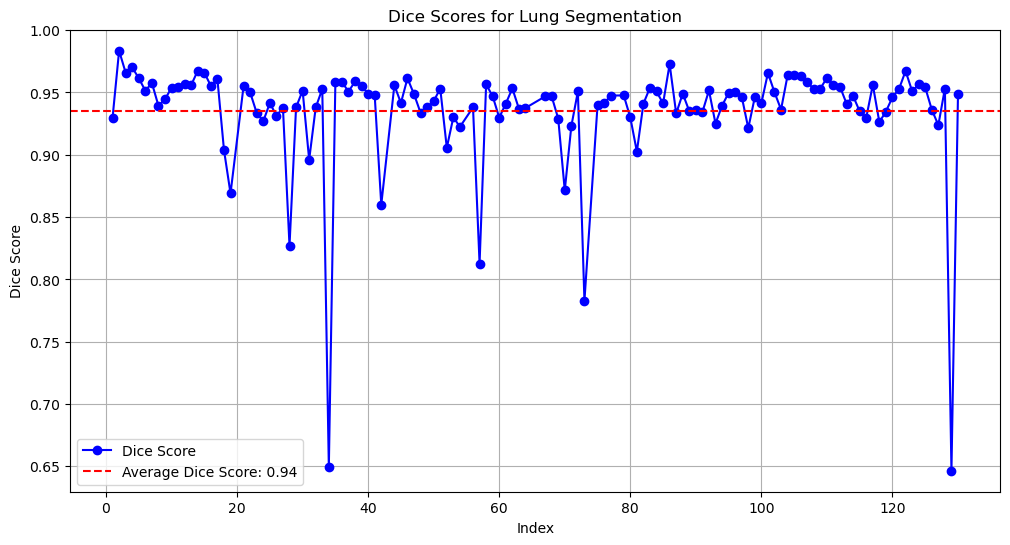

In [8]:

import numpy as np

# Convert dice_scores to a numpy array
dice_scores_array = np.array(dice_scores)
# Save dice_scores to a file
np.savetxt('dice_scores.txt', dice_scores_array, fmt='%f', delimiter=',', header='Dice Score, Index')

# Plot the Dice scores
plt.figure(figsize=(12, 6))
plt.plot(dice_scores_array[:, 1], dice_scores_array[:, 0], marker='o', linestyle='-', color='b', label='Dice Score')
plt.axhline(y=average_dice_score, color='r', linestyle='--', label=f'Average Dice Score: {average_dice_score:.2f}')
plt.xlabel('Index')
plt.ylabel('Dice Score')
plt.title('Dice Scores for Lung Segmentation')
plt.legend()
plt.grid(True)
plt.show()